In [4]:
import os
import numpy as np

import vtkmodules.all as vtk
from vtkmodules.util.numpy_support import vtk_to_numpy, numpy_to_vtk

import meshio
from scipy.spatial.distance import cdist
# from scipy.sparse import load_npz

# TO EXECUTE THIS CELL, YOU NEED TO INSTALL THE FOLLOWING LIBRARIES: numpy, vtk, meshio, scipy

# 1. Load the bases

In the Navier-Stokes problem we have two solution fields: velocity and pressure. Exploiting Proper Orthogonal Decomposition (POD), given a set of available solutions, I have pre-computed bases in space and in time for both fields, which are represented as matrices and imported in the following cell. Each basis matrix has a number of rows equal to the number of unkowns in the full-order problem (FOM) and a number of columns equal to the number of POD modes. Since the former is much larger than the latter, these matrices are tall and thin. 

**Remark:** *Concerning the velocity bases, we delete some "extra" basis functions, that have been added only to guarantee the stability of the Space-Time Reduced Basis (ST-RB) method. These functions are called "supremizers" for the spatial basis and "stabilizers" for the temporal basis.*

In [5]:
DATASET_PATH= "/Users/manuelcurnis/Downloads/dataset"

In [6]:
!pip install vtk
!pip install meshio

In [7]:
fields = {'velocity', 'pressure'}

basis_space, sv_space, Nh_space, nmodes_space = dict(), dict(), dict(), dict()
basis_time, sv_time, Nh_time, nmodes_time = dict(), dict(), dict(), dict()
nmodes = dict()
for field in fields:
    basis_space[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'space_basis.npy'))  # spatial basis
    sv_space[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'space_sv.npy'))  # singular values in space
    Nh_space[field], nmodes_space[field] = basis_space[field].shape  # number of FOM and ROM unknowns in space
    basis_time[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'time_basis.npy'))  # temporal basis
    sv_time[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'time_sv.npy'))  # singular values in time
    Nh_time[field], nmodes_time[field] = basis_time[field].shape  # number of FOM and ROM unknowns in time 
    nmodes[field] = nmodes_space[field] * nmodes_time[field]  # total dimension of the reduced basis
    
# UPDATE VELOCITY BASES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
N_supr_space = basis_space['pressure'].shape[1] + 66  # number of extra bases in space for the velocity
N_supr_time = 5  # number of extra bases in time for the velocity

# STORE ORIGINAL NUMBER OF VELOCITY MODES IN THE DICTIONARY
nmodes_space['velocity_full'] = nmodes_space['velocity']
nmodes_time['velocity_full'] = nmodes_time['velocity']
nmodes['velocity_full'] = nmodes['velocity']

# UPDATE THE NUMBER OF VELOCITY MODES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
nmodes_space['velocity'] -= N_supr_space
nmodes_time['velocity'] -= N_supr_time
nmodes['velocity'] = nmodes_space['velocity'] * nmodes_time['velocity']

# UPDATE VELOCITY BASES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
basis_space['velocity'] = basis_space['velocity'][:, :nmodes_space['velocity']]
basis_time['velocity'] = basis_time['velocity'][:, :nmodes_time['velocity']]

# LOAD NORMED BASIS MATRICES IN SPACE (needed for projections)
basis_space_normed = dict()
#norm = dict()
for field in fields:
    #norm[field] = load_npz(os.path.join('dataset', 'norms', f'norm_{field}.npz'))
    #basis_space_normed[field] = norm[field].dot(basis_space[field])
    #np.save(os.path.join('dataset', 'basis', field, 'basis_space_normed.npy'), basis_space_normed[field])
    basis_space_normed[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'basis_space_normed.npy'))

In [8]:
basis_space['velocity'].shape  

(76974, 39)

In [9]:
basis_space['pressure'].shape

(3552, 9)

In [10]:
basis_time['velocity'].shape

(1000, 16)

In [11]:
basis_time['pressure'].shape

(1000, 19)

= (FOM X ROM)

each basis matrix has a number of rows equal to the number of unkowns in the full-order problem (FOM) and a number of columns equal to the number of POD modes ,represent the most significant patterns in the data.

# 2. Load the solutions

For each solution, we store the associated space-time reduced coefficients (i.e. the reduced solution). In the dataset, for each parameter value the solutions are stored in vectors, which comprise space-time coefficients for all the fields involved. 

We can manipulate the solution vectors to store solutions corresponding to different fields in different matrices. Each matrix storing a reduced solution has a number of rows equal to the number of modes in space and a number of columns equal to the number of modes in time. For the velocity, we only consider the "small" bases, i.e. the bases without "extra" elements (called supremizers in space and stabilizers in time). In fact, such extra bases are only needed to guarantee the stability of the ST-RB method.

**Ultimately, each solution is encoded in a 3D matrix, whose dimensions are, respectively, the number of datapoints, the number of modes in space and the number of modes in time.**

**Remark**: *the solutions to be used (1950 datapoints) are stored in the 'RB_data' folder. Additional 50 solutions can be found in the 'FOM_data' folder, but we discard them for the time being.*

In [12]:
n_snaps = None  # change to a number if you want to load only a subset of snapshots
_sol = np.load(os.path.join(DATASET_PATH, 'RB_data', 'solutions.npy'))[:n_snaps]

solutions = dict()

# velocity reduced solutions (with and without supremizers and stabilizers)
solutions['velocity_full'] = np.reshape(_sol[:, :nmodes['velocity_full']], 
                                        (-1, nmodes_space['velocity_full'], nmodes_time['velocity_full']))
solutions['velocity'] = solutions['velocity_full'][:, :nmodes_space['velocity'], :nmodes_time['velocity']]

# pressure reduced solutions
solutions['pressure'] = np.reshape(_sol[:, :nmodes['pressure']], 
                                   (-1, nmodes_space['pressure'], nmodes_time['pressure']))

In [13]:
solutions['pressure'].shape

(1950, 9, 19)

In [14]:
solutions['velocity'].shape

(1950, 39, 16)

In [15]:
# functions to project and expand solutions

def project(sol, normed_basis_space, basis_time):
    """ Project a full-order solution in space-time."""
    return (normed_basis_space.T.dot(sol)).dot(basis_time) # !! REMARK: here we need the normed basis in space !!

def expand(sol, basis_space, basis_time):
    """ Expand a reduced-order solution in space-time."""
    return (basis_space.dot(sol)).dot(basis_time.T)

In [ ]:
expand(solutions['pressure'], basis_space['pressure'], basis_time['pressure']).shape

# 3. Load the parameters

To be able to solve the Navier-Stokes equations, it is compulory to prescribe initial conditions (i.e. how is the solution at $t=0$) and boundary conditions (i.e. how velocity and/or pressure behave at the boundaries of the domain). The domain boundaries are the lateral wall, the inlet and the two outlets. For this test case, we considered:

* initial conditions equal to $0$;
* velocity equal to $0$ on the lateral boundary (as if the artery is rigid, which is evidently an assumption);
* velocity such that the volumetric flow rate matches a prescribed target at the inlet;
* velocity such that the volumetric flow rate matches a prescribed target at one outlet;
* pressure equal to $0$ (not really, but that's ok) at the other outlet.

Each simulation is characterized by 3 parameters. The original parameter vector has length 4, but the third entry is always equal to 1 and can be safely discarded.

At the inlet of the bifurcation, we impose a prescribed volumetric flow rate (mL of blood per second) of the form: $$ Q_{in}(t) = 1 - \cos\left(\frac{2\pi t}{T}\right) + \mu_1 \sin\left(\mu_2 \frac{2\pi t}{T}\right)~, $$ where $T=1 \ s$ is the final time of the simulation. Therefore, the first two parameters encode the following information:

* $\mu_1$: frequency of the oscillations in the flow rate. Bounds: (4.0, 8.0);
* $\mu_2$: amplitude of the oscillations in the flow rate. Bounds: (0.1, 0.3).

At one of the outlets, instead, we enforce the flow rate $Q_{out}(t) = \mu_3 \ Q_{in}(t)$. Thus, the parameter $\mu_3$ (Bounds: $(0.2,0.8)$) represents the fraction of blood that exists the domain via the first outlet. 

**The parameter vectors represent the input of the model!**

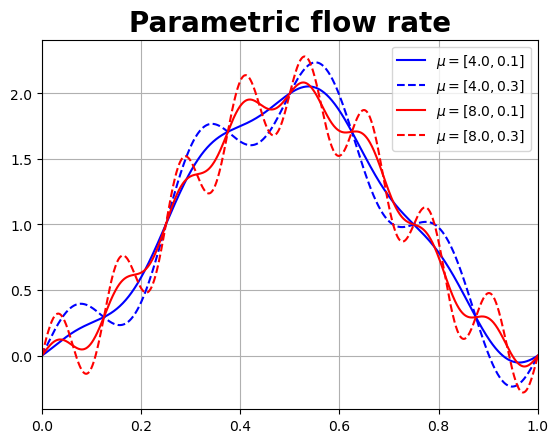

In [16]:
import matplotlib.pyplot as plt

Q = lambda t, mu, T=1: 1 - np.cos(2*np.pi*t/T) + mu[1] * np.sin(mu[0]*2*np.pi*t/T)

times = np.linspace(0,1,1000)
plt.plot(times, Q(times, [4.0, 0.1]), 'b-', label=r"$\mu = [4.0, 0.1]$")
plt.plot(times, Q(times, [4.0, 0.3]), 'b--', label=r"$\mu = [4.0, 0.3]$")
plt.plot(times, Q(times, [8.0, 0.1]), 'r-', label=r"$\mu = [8.0, 0.1]$")
plt.plot(times, Q(times, [8.0, 0.3]), 'r--', label=r"$\mu = [8.0, 0.3]$")

plt.grid()
plt.xlim([0,1])
plt.legend()
plt.title("Parametric flow rate", fontweight='bold', fontsize=20)
plt.show()

In [17]:
params = np.load(os.path.join(DATASET_PATH, 'RB_data', 'parameters.npy'))
params = np.delete(params, 2, axis=1)  # one column is useless and we delete it 

In [18]:
params.shape

(1950, 3)

In [19]:
solutionss = np.load(os.path.join(DATASET_PATH, 'RB_data', 'solutions.npy'))

In [20]:
solutionss.shape

(1950, 3807)

# 4. Visualize the solutions

The function ``visualize_solution`` allows to export the solution (velocity, pressure) as a ``.vtu`` file, which is stored in the *solutions/* folder. The file can be opened e.g. with [Paraview](https://www.paraview.org/). 

In [ ]:
def read_vtk(filename):
    """Read .vtk file and return the polydata"""

    fn_dir, fn_ext = os.path.splitext(filename)

    if fn_ext == '.vtk':
        reader = vtk.vtkPolyDataReader()
    elif fn_ext == '.vtp':
        reader = vtk.vtkXMLPolyDataReader()
    elif fn_ext == '.stl':
        reader = vtk.vtkSTLReader()
    elif fn_ext == '.obj':
        reader = vtk.vtkOBJReader()
    elif fn_ext == '.vtu':
        reader = vtk.vtkXMLUnstructuredGridReader()
    elif fn_ext == '.pvtu':
        reader = vtk.vtkXMLPUnstructuredGridReader()
    else:
        raise ValueError(F"File extension {fn_ext} not supported")

    reader.SetFileName(filename)
    reader.Update(0)
    mesh = reader.GetOutput()

    return mesh

def write_vtk(mesh, fn):
    """ Write a mesh (vtk polydata or unstructured grid) to disk """

    _, extension = os.path.splitext(fn)

    if extension == '.vtk':
        writer = vtk.vtkPolyDataWriter()
    elif extension == '.stl':
        writer = vtk.vtkSTLWriter()
    elif extension == '.vtp':
        writer = vtk.vtkXMLPolyDataWriter()
    elif extension == '.vtu':
        writer = vtk.vtkXMLUnstructuredGridWriter()
    elif extension == '.obj':
        writer = vtk.vtkOBJWriter()
    else:
        raise ValueError(f"Unrecognized extension {extension}")

    writer.SetInputData(mesh)
    writer.SetFileName(fn)
    writer.Update(0)
    writer.Write()

    return

def add_array(mesh, array, name): 
    """Add numpy array as new field to a vtk file"""

    new_array = numpy_to_vtk(array)
    new_array.SetName(name)
    mesh.GetPointData().AddArray(new_array)

    return mesh

In [ ]:
def compute_matching_idxs():
    """Compute correspondences bewteen indices on the .vtu and on the .mesh file for plotting"""
    
    mesh = read_vtk(os.path.join('dataset', 'geometries', 'bif_sym_alpha50_h0.10_ref.vtu'))
    points = vtk_to_numpy(mesh.GetPoints().GetData())
    
    mesh_2 = meshio.read(os.path.join('dataset', 'geometries','bif_sym_alpha50_h0.10.mesh'))
    points_2 = mesh_2.points
    
    dist = cdist(mesh_2.points, points, metric='euclidean')
    
    idxs = np.argmin(dist, axis=0)
    
    return idxs

In [ ]:
def visualize_solution(n, fields=None, step_t=10):
    """ Export the solution corresponding to the n-th snapshot (every step_t steps) to a .vtu file."""
    
    if fields is None:
        fields = {'velocity': 3, 'pressure': 1}  # fields and corresponding dimensions
        
    os.makedirs('solutions', exist_ok=True)
    
    idxs = compute_matching_idxs()
    
    mesh = read_vtk(os.path.join('dataset', 'geometries', 'bif_sym_alpha50_h0.10.vtu'))
    
    fom_solution = dict()
    for field in fields:
        # print(f"Processing field {field} - Dimension: {fields[field]}")
        cur_idxs = np.hstack([idxs + k * (Nh_space[field]//fields[field]) for k in range(fields[field])])
        fom_solution[field] = expand(solutions[field][n], basis_space[field], basis_time[field])[cur_idxs]
    
    for cnt_t in range(0, Nh_time['velocity'], step_t):
        # print(f"\nProcessing timestep {cnt_t} of {Nh_time['velocity']}")
        for field in fields:
            cur_fom_solution = np.reshape(fom_solution[field][:, cnt_t], (fields[field], -1)).T
            mesh = add_array(mesh, cur_fom_solution, field)
    
        write_vtk(mesh, os.path.join('solutions', f"solution_{n}_{cnt_t}" + '.vtu'))
    
    return

In [ ]:
visualize_solution(0, step_t=5)